## ***Comparison between models***

### Visual results

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display, HTML, Video

model_names = ["finetuned_sam2", "base_sam2", "yolo_seg"]
video_id = "video_45"
viz_dir = "/data/mkondrac/foundation_model_cardio/code/SAM/yolo_sam/evaluation/evaluations/visualisation"

# Build HTML to show videos side by side
html_videos = ""
for model_name in model_names:
    video_path = f"{viz_dir}/{model_name}_segmentation_video.avi"
    html_videos += f"""
    <div style="display:inline-block; margin:10px; text-align:center;">
        <video width="320" controls>
            <source src="{video_path}" type="video/avi">
            Your browser does not support the video tag.
        </video>
        <br>{model_name}
    </div>
    """

display(HTML(html_videos))

### Segmentation results

In [3]:
from eval_help import evaluate_dataset

CLASSES = {
    1: "Tool clasper",
    2: "Tool wrist",
    3: "Tool shaft",
    4: "Suturing needle",
    5: "Thread",
    6: "Suction tool",
    7: "Needle Holder",
    8: "Clamps",
    9: "Catheter",
}

In [ ]:
import warnings
warnings.filterwarnings("ignore")

for model_name in model_names:
    print(f"Evaluation of {model_name}")
    videos = [f"video_{i}" for i in range(41, 51)]
    pred_root = f"/data/mkondrac/foundation_model_cardio/code/SAM/yolo_sam/results/{model_name}_out"
    gt_root = "/data/mkondrac/foundation_model_cardio/code/SAM/data/SAR-RARP50_test_set"

    evaluate_dataset(model_name, videos, pred_root, gt_root, json_name="evaluation_results.json")
    

Evaluation of finetuned_sam2


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [02:05<00:00, 12.58s/it]


Evaluation of base_sam2


 60%|██████    | 6/10 [01:14<00:54, 13.72s/it]

In [ ]:
results_dir = "/data/mkondrac/foundation_model_cardio/code/SAM/yolo_sam/results"

all_video_metrics = []
all_class_metrics = []

for model_name in model_names:
    json_path = os.path.join(results_dir, f"{model_name}_out", "evaluation_results.json")
    with open(json_path, "r") as f:
        data = json.load(f)
    
    for video, frames in data["videos"].items():
        for frame_id, metrics in frames.items():
            # Store per-frame video metrics (not averaged)
            all_video_metrics.append({
                "model": model_name,
                "video": video,
                "frame": frame_id,
                "mIoU": metrics["mIoU"],
                "NSD": metrics["NSD"]
            })
            
            # Store per-class metrics
            for cls, iou in metrics["per_class_iou"].items():
                dice = metrics["per_class_dice"][cls]
                all_class_metrics.append({
                    "model": model_name,
                    "video": video,
                    "frame": frame_id,
                    "class": CLASSES.get(int(cls), f"Class {cls}"),
                    "IoU": iou,
                    "Dice": dice
                })

video_df = pd.DataFrame(all_video_metrics)
class_df = pd.DataFrame(all_class_metrics)


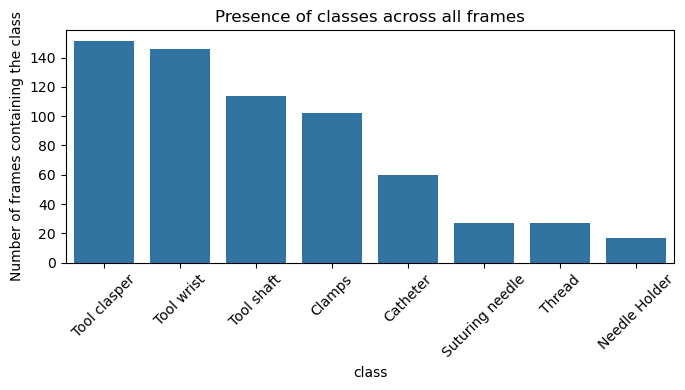

In [ ]:
class_presence = []

for model_name in model_names:  # can use any model just to read the JSON
    json_path = os.path.join(results_dir, f"{model_name}_out", "evaluation_results.json")
    with open(json_path, "r") as f:
        data = json.load(f)
    break  # we only need one model's JSON

for video, frames in data["videos"].items():
    for frame_id, metrics in frames.items():
        for cls in metrics["per_class_iou"].keys():
            class_presence.append(CLASSES.get(int(cls), f"Class {cls}"))

# Create a DataFrame
presence_df = pd.DataFrame(class_presence, columns=["class"])

# Count occurrences of each class
counts = presence_df.value_counts().reset_index()
counts.columns = ["class", "frame_count"]

# Plot histogram
plt.figure(figsize=(7,4))
sns.barplot(x="class", y="frame_count", data=counts)
plt.title("Presence of classes across all frames")
plt.xticks(rotation=45)
plt.ylabel("Number of frames containing the class")
plt.tight_layout()
plt.show()

### Segmentation results

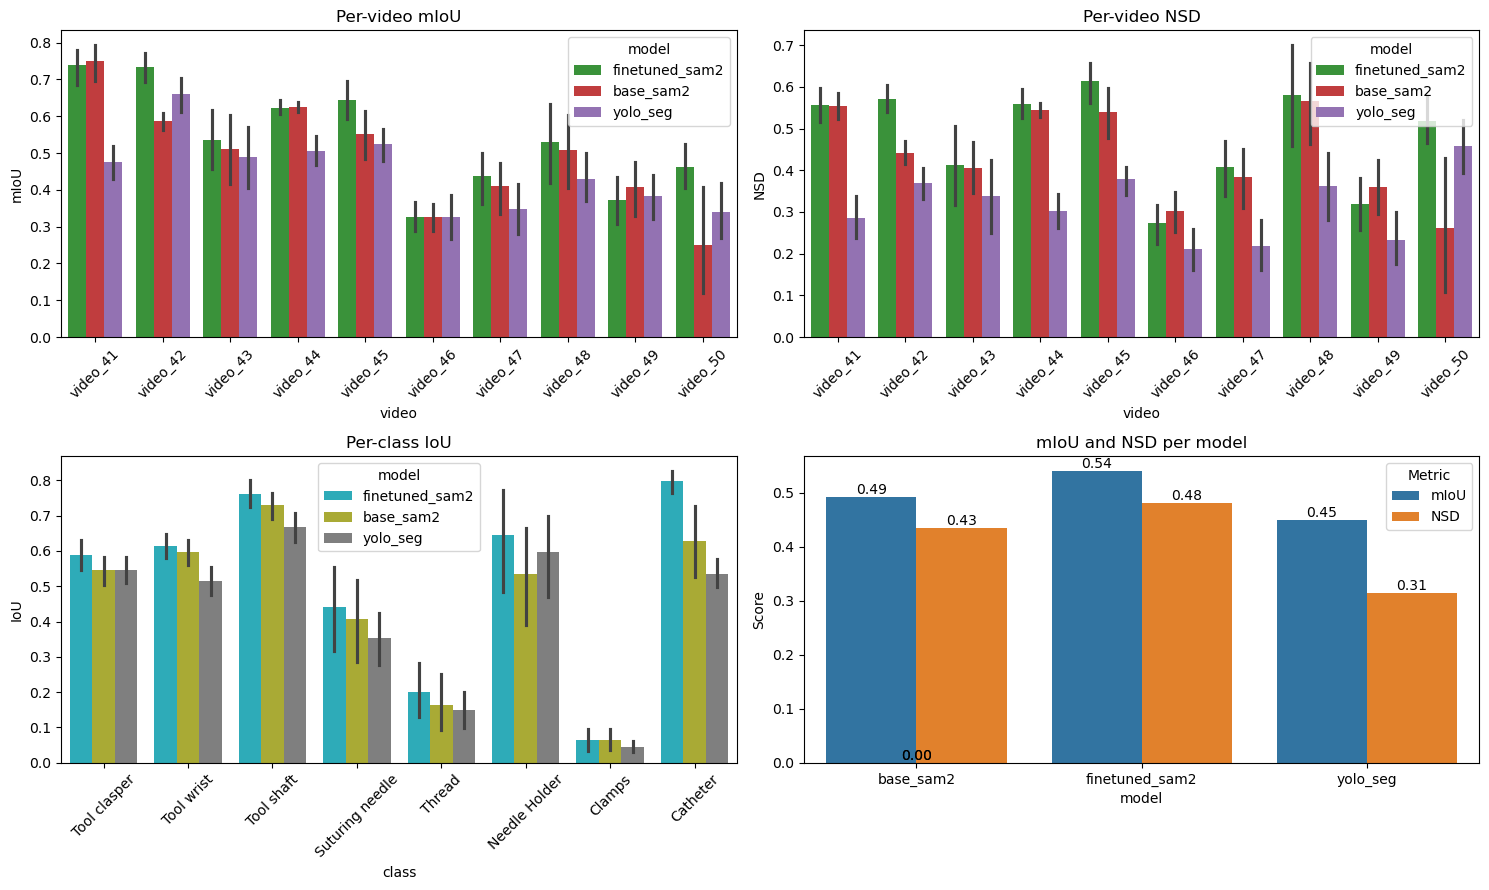

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 9))

video_palette = ["#2ca02c", "#d62728", "#9467bd"]  # green, red, purple
class_palette = ["#17becf", "#bcbd22", "#7f7f7f"]  # cyan, yellow, gray
score_palette = ["#1f77b4", "#ff7f0e"]  # blue, orange

# per-video mIoU
sns.barplot(x="video", y="mIoU", hue="model", data=video_df, ax=axes[0,0], palette=video_palette)
axes[0,0].set_title("Per-video mIoU")
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)

# per-video NSD
sns.barplot(x="video", y="NSD", hue="model", data=video_df, ax=axes[0,1], palette=video_palette)
axes[0,1].set_title("Per-video NSD")
axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45)

# per-class IoU
sns.barplot(x="class", y="IoU", hue="model", data=class_df, ax=axes[1,0], palette=class_palette)
axes[1,0].set_title("Per-class IoU")
axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45)

# overall mIoU per model
overall_metrics = video_df.groupby("model")[["mIoU", "NSD"]].mean().reset_index()
overall_metrics_long = overall_metrics.melt(
    id_vars="model", value_vars=["mIoU", "NSD"], 
    var_name="Metric", value_name="Score"
)
sns.barplot(x="model", y="Score", hue="Metric", data=overall_metrics_long, ax=axes[1,1], palette=score_palette)
axes[1,1].set_title("mIoU and NSD per model")
axes[1,1].set_ylabel("Score")
# add values on the top of bars
for p in axes[1,1].patches:
    height = p.get_height()
    axes[1,1].annotate(
        f'{height:.2f}',          # show 2 decimal places
        (p.get_x() + p.get_width() / 2., height),  # x,y position
        ha='center', va='bottom',  # center horizontally, above bar
        fontsize=10
    )

plt.tight_layout()
plt.show()

### Detection results from YOLO 

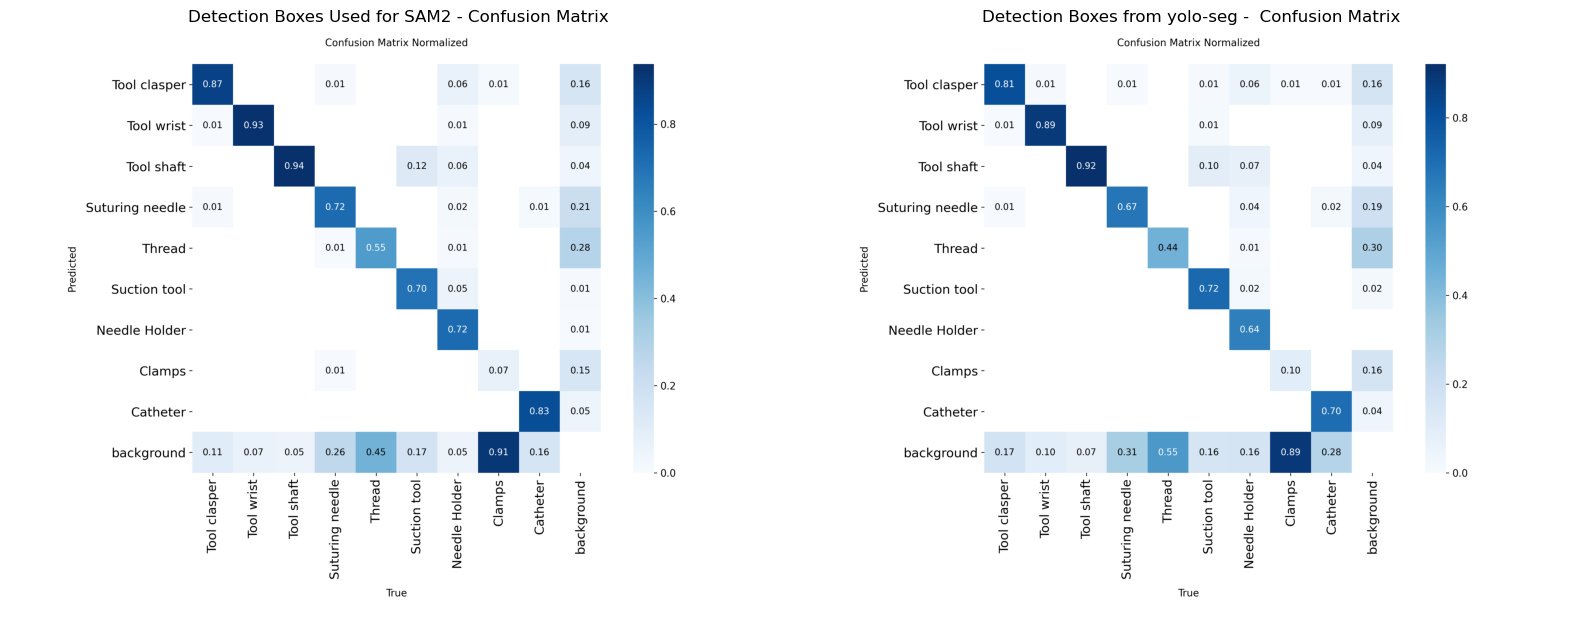

In [ ]:
import matplotlib.image as mpimg

# Paths to your images
det_cm_path = "/data/mkondrac/foundation_model_cardio/code/SAM/yolo_sam/yolo/surgical_tools_det/yolo11n_surgery/confusion_matrix_normalized.png"
seg_cm_path = "/data/mkondrac/foundation_model_cardio/code/SAM/yolo_sam/yolo/surgical_tools_seg/yolo11n_surgery/confusion_matrix_normalized.png"

# Load images
det_img = mpimg.imread(det_cm_path)
seg_img = mpimg.imread(seg_cm_path)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Detection confusion matrix
axes[0].imshow(det_img)
axes[0].axis('off')
axes[0].set_title("Detection Boxes Used for SAM2 - Confusion Matrix")

# Segmentation confusion matrix
axes[1].imshow(seg_img)
axes[1].axis('off')
axes[1].set_title("Detection Boxes from yolo-seg -  Confusion Matrix")

plt.tight_layout()
plt.show()


### Inference Time Comparison

In [ ]:
videos = [f"video_{i}" for i in range(41, 51)]
results_dir = "/data/mkondrac/foundation_model_cardio/code/SAM/yolo_sam/results"

all_times = []

for model_name in model_names:
    for video in videos:
        json_path = os.path.join(
            results_dir, f"{model_name}_out", f"{video}_frame_by_frame", "summary_inference.json"
        )
        with open(json_path, "r") as f:
            data = json.load(f)
        
        video_dict = data.get(video, {})  # adjust key if necessary
        frame_times = next(iter(video_dict.values()))
        for frame_id, t in frame_times.items():
            all_times.append({
                "model": model_name,
                "video": video,
                "frame": int(frame_id),
                "time_ms": t*1000
            })
            
times_df = pd.DataFrame(all_times)

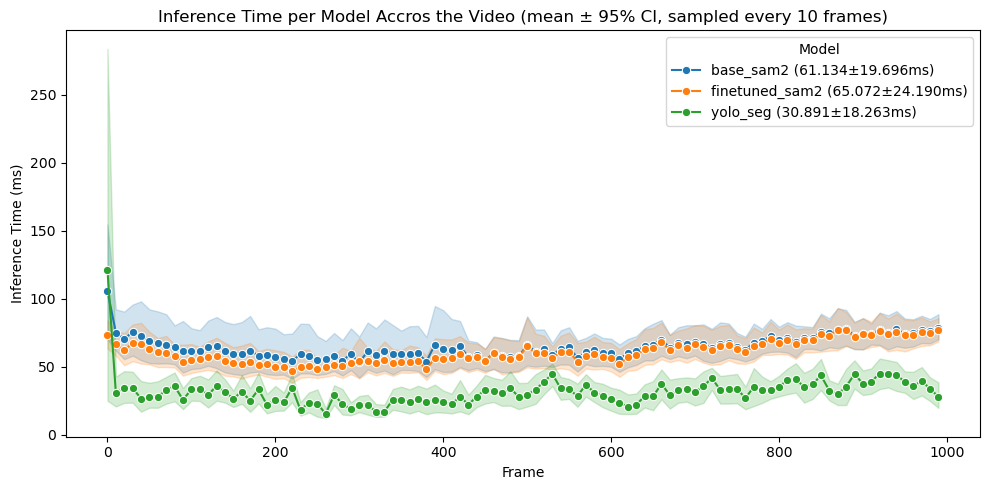

In [ ]:
times_df_sampled = times_df[times_df["frame"] % 10 == 0]

overall_stats = times_df.groupby("model")["time_ms"].agg(["mean","std"]).reset_index()
model_labels = [f"{row.model} ({row.mean:.3f}±{row.std:.3f}ms)" for row in overall_stats.itertuples()]

plt.figure(figsize=(10,5))
sns.lineplot(
    x="frame", y="time_ms", hue="model", data=times_df_sampled,
    estimator="mean", ci=95, marker="o"
)
plt.title("Inference Time per Model Accros the Video (mean ± 95% CI, sampled every 10 frames)")
plt.xlabel("Frame")
plt.ylabel("Inference Time (ms)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=model_labels, title="Model")
plt.tight_layout()
plt.show()